# Scheduler Benchmark (Sweep Resources)

- Sweep over the number of resources for the Azure packing 2020 dataset, using synthetically augmented
- We fix the total number of jobs (4.096M jobs), but downsample this to get a total of 32000 jobs
- We choose a set of values for the number of machines and sweep this value
- $M = 20$ machines

Schedulers:
```
schedulers = [
        MRIS(sort='WSJF'),
        PriorityQueue(sort='WSJF', collect=True),
        OnlinePriorityQueue(sort='WSJF'),
        TetrisScheduler(),
        BFEXECScheduler()
]
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from pathlib import Path
import itertools
import scipy.stats as st

In [2]:
plt.style.use(['science'])
params = {
    "font.family": "serif",
    "text.usetex": True,
    'text.latex.preamble':
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
def get_linestyles():
     return itertools.cycle([
         ('solid', (0, ())),
         # ('loosely dotted',        (0, (1, 10))),
         ('dotted',                (0, (1, 1))),
         # ('densely dotted',        (0, (1, 1))),
         ('long dash with offset', (5, (10, 3))),
         ('loosely dashed',        (0, (5, 10))),
         #('dashed',                (0, (5, 5))),
         ('densely dashed',        (0, (5, 1))),
    
         #('loosely dashdotted',    (0, (3, 10, 1, 10))),
         ('dashdotted',            (0, (3, 5, 1, 5))),
         ('densely dashdotted',    (0, (3, 1, 1, 1))),
    
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ])
mpl.rcParams.update(params)

# Input Parameters

In [3]:
# This defines the downsample factors used in the simulation
RESOURCES = np.arange(4, 20+1)

# Number of runs per downsample factor (each factor must have the same number of runs)
NUM_RUNS = 10

# Path to the results folder
PATH_TO_RESULTS = Path('./results/')

# Plot AWCT

In [4]:
awct_data = {}
for i, R in enumerate(RESOURCES):
    for run in range(1, NUM_RUNS + 1):
        data = pd.read_parquet(PATH_TO_RESULTS / Path(f'5_scheduler_benchmark_resources_{R}_{run}.parquet'))
        schedulers = list(data['scheduler'].unique())
        for scheduler in schedulers:
            df = data[data['scheduler'] == scheduler]
            weighted_completion_time = df['C'].dot(df['w']) / len(df)
            vals = awct_data.get(scheduler, np.zeros(shape=(len(RESOURCES), NUM_RUNS)).astype(float))
            vals[i][run-1] = weighted_completion_time
            awct_data[scheduler] = vals

In [5]:
awct_x = {scheduler:np.mean(data, axis=1) for scheduler, data in awct_data.items()}
# 95 % Confidence Intervals
awct_error = {scheduler:st.t.interval(0.95, df=data.shape[1]-1, loc=np.mean(data, axis=1), scale=st.sem(data, axis=1)) for scheduler, data in awct_data.items()}

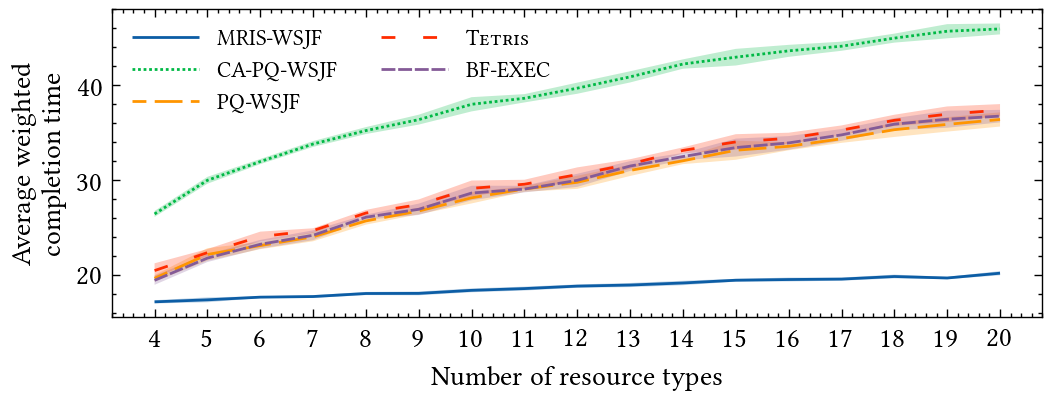

In [6]:
plt.figure(figsize=(6, 2), dpi=200)

linestyles = get_linestyles()
for scheduler, weighted_completion_times in awct_x.items():
    if scheduler == 'Tetris-instantaneous':
        label = r'\textsc{Tetris}'
    elif scheduler == 'PQ-WSJF':
        label = 'CA-PQ-WSJF'
    elif scheduler == 'OnlinePQ-WSJF':
        label = 'PQ-WSJF'
    else:
        label = scheduler
    plt.plot(RESOURCES, weighted_completion_times, label=label, linestyle=next(linestyles)[1])
    plt.fill_between(RESOURCES, awct_error[scheduler][0], awct_error[scheduler][1], alpha=0.25)
plt.xticks(RESOURCES, RESOURCES)
# plt.yscale('log', base=2)
plt.ylabel("Average weighted\n completion time")
plt.xlabel(r"Number of resource types")
plt.legend(prop={'size': 8}, handlelength=3, ncol=2)
plt.savefig('resource_sweep.pdf', bbox_inches='tight')
plt.show()